In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import pdb

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(97)

In [2]:
final_design_seqs_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/"
ensemble_predictions_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/ensemble_predictions/"

In [3]:
os.listdir(ensemble_predictions_dir)

['filtered_ensemble_1_predictions.parquet',
 'dataset_seqs_eval_2.pkl',
 'filtered_coms_sequences_ensemble_2_6mer_counts_pairwise_euclidean_distances.npy',
 'filtered_coms_sequences_ensemble_4.parquet',
 'den_seqs_eval_4.pkl',
 'dataset_seqs_eval_3.pkl',
 'filtered_dens_sequences_ensemble_4_DENs_v14.parquet',
 'all_ensemble_2_predictions.parquet',
 'all_ensemble_4_predictions_DENs_v14.parquet',
 'sequences_from_batch_1_expression_spectrum_eval_4.pkl',
 'filtered_coms_sequences_ensemble_1_6mer_counts.npy',
 'filtered_coms_sequences_ensemble_2_6mer_counts.npy',
 'filtered_dens_sequences_ensemble_4.parquet',
 'filtered_ensemble_4_predictions.parquet',
 'filtered_ensemble_4_predictions_DENs_v14.parquet',
 'den_seqs_v14_eval_3.pkl',
 'all_ensemble_predictions.parquet',
 'filtered_ensemble_2_predictions.parquet',
 'filtered_dens_sequences_ensemble_1.parquet',
 'dataset_seqs_eval.pkl',
 'filtered_ensemble_3_predictions.parquet',
 'filtered_dens_sequences_ensemble_3.parquet',
 'all_ensemble_1_

In [4]:
# NOTE: ensemble 0 is the original ensemble 3 and ensemble 1 is the original ensemble 4
ensemble_0_filtered_sequences = pd.read_parquet(os.path.join(ensemble_predictions_dir, 
                                                             "filtered_ensemble_3_predictions_DENs_v14.parquet"))
ensemble_1_filtered_sequences = pd.read_parquet(os.path.join(ensemble_predictions_dir, 
                                                             "filtered_ensemble_4_predictions_DENs_v14.parquet"))

coms None
jurkat
k562
thp1


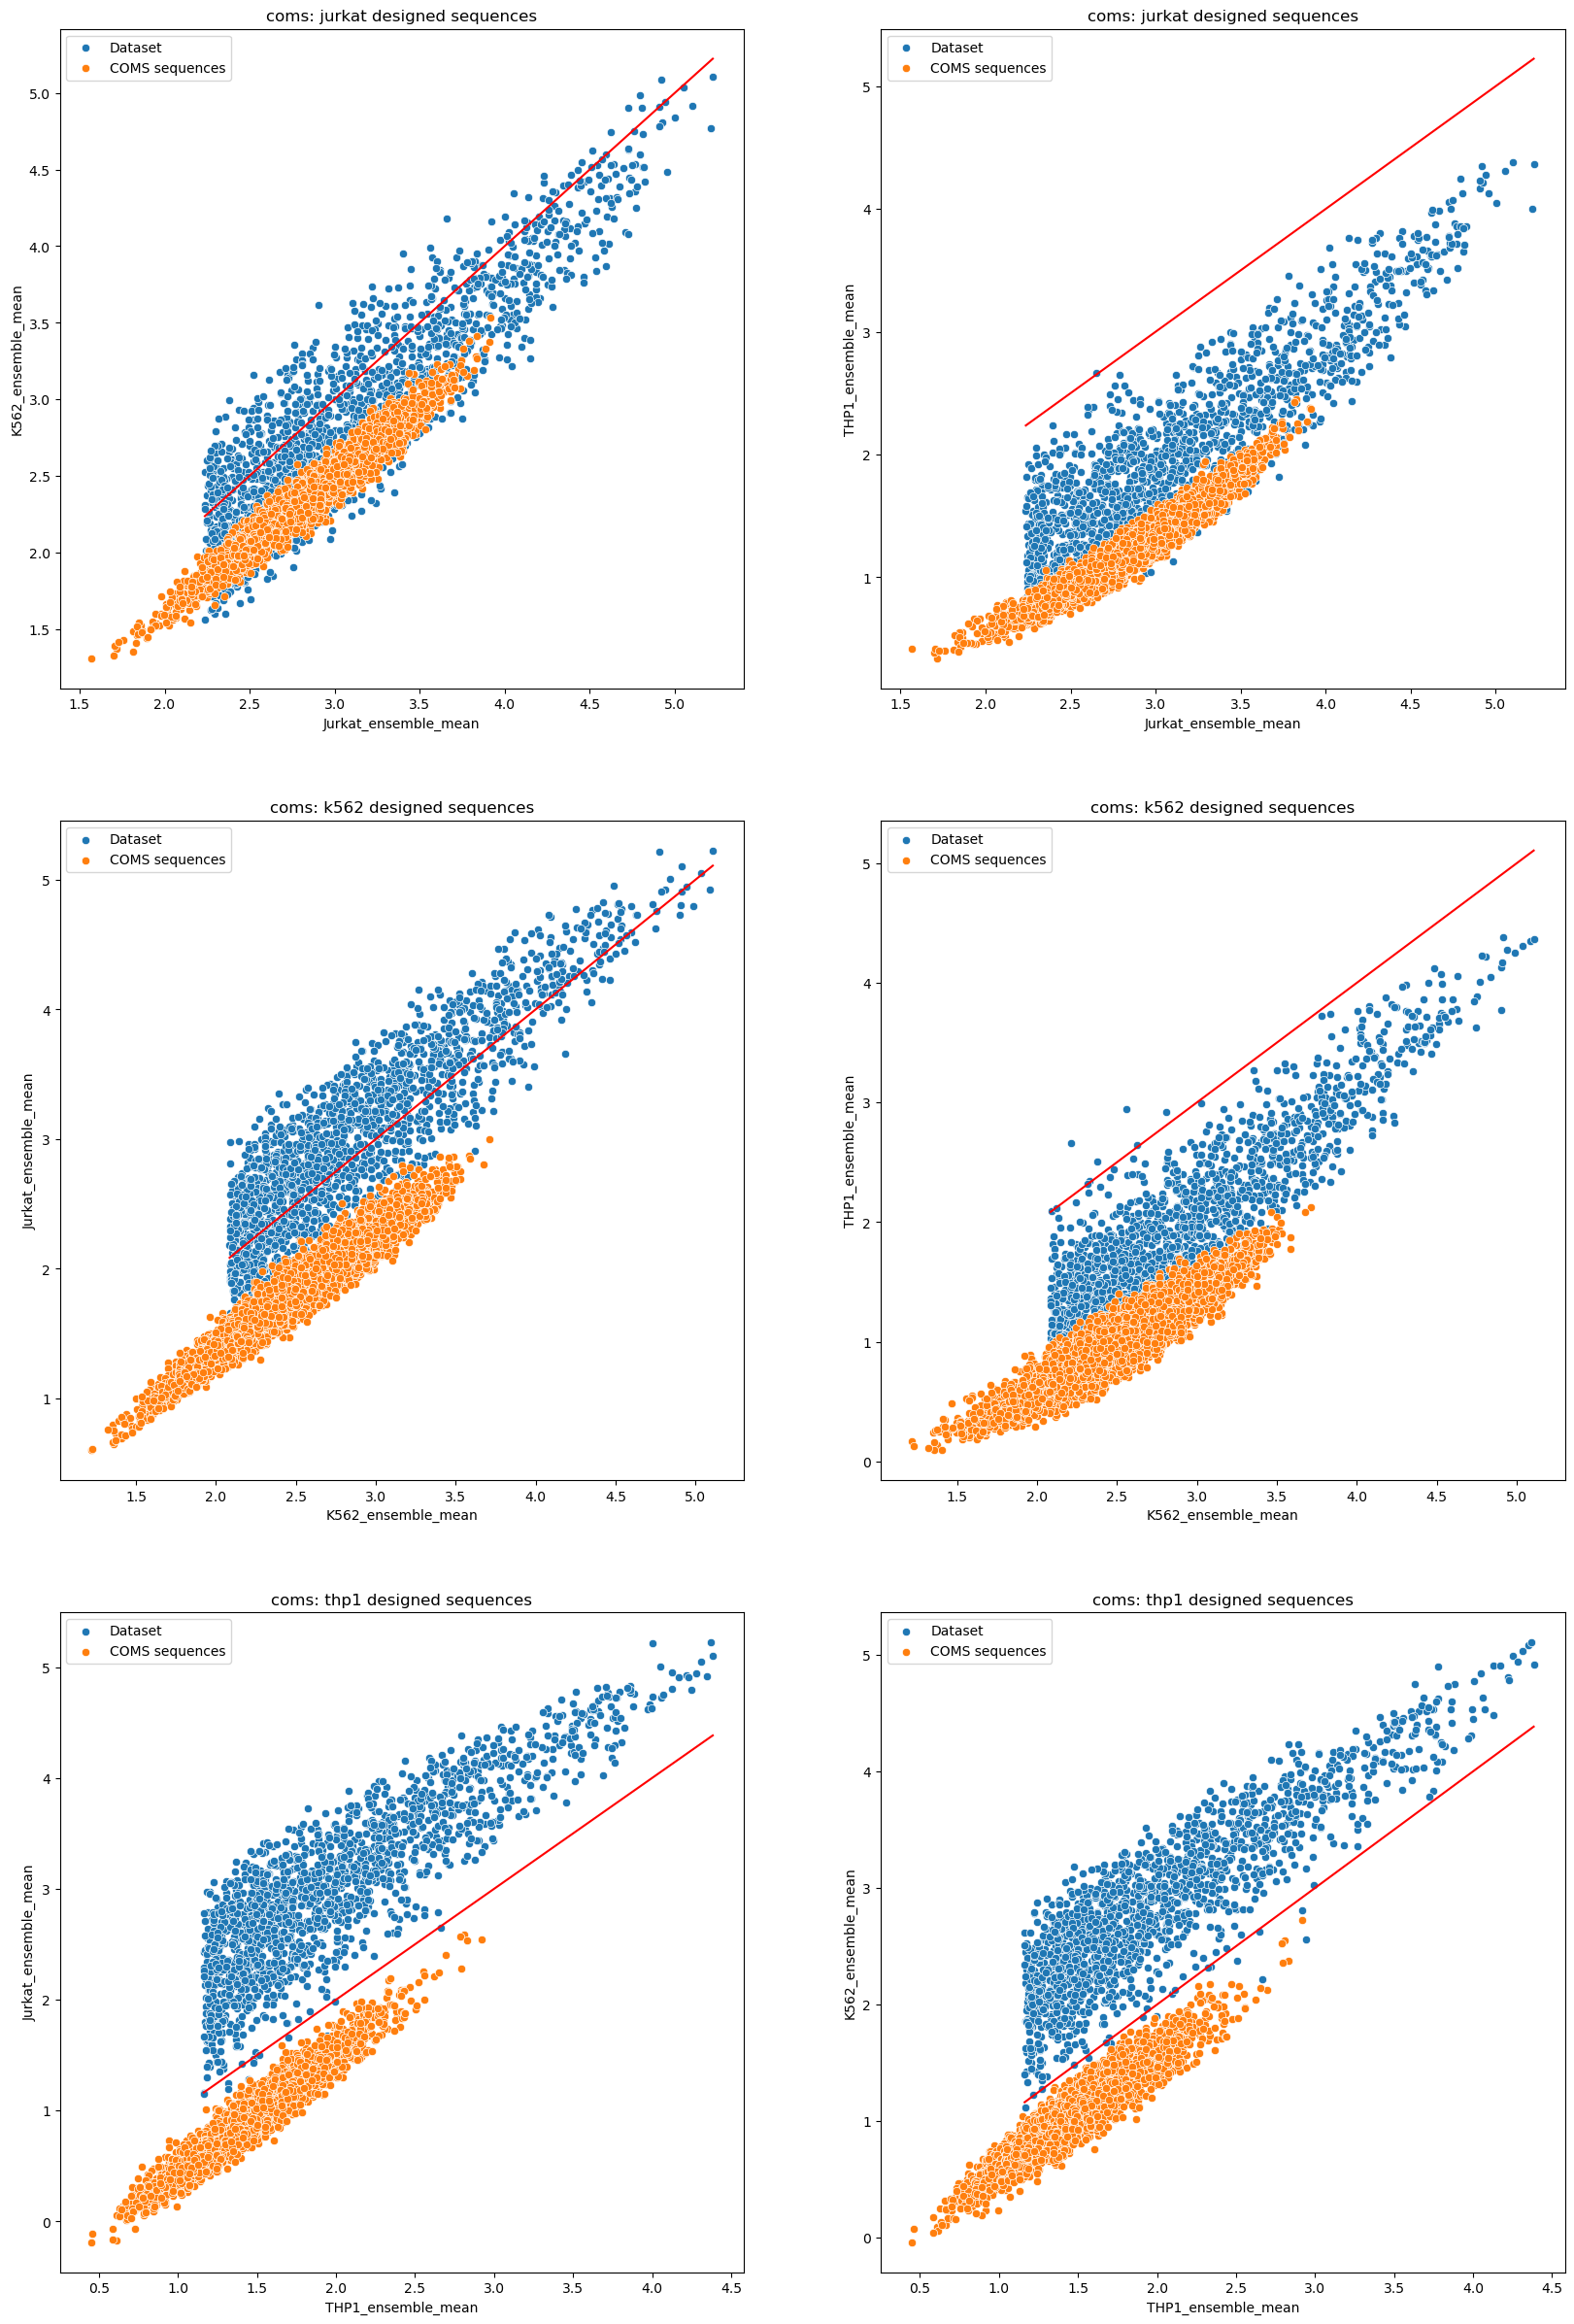

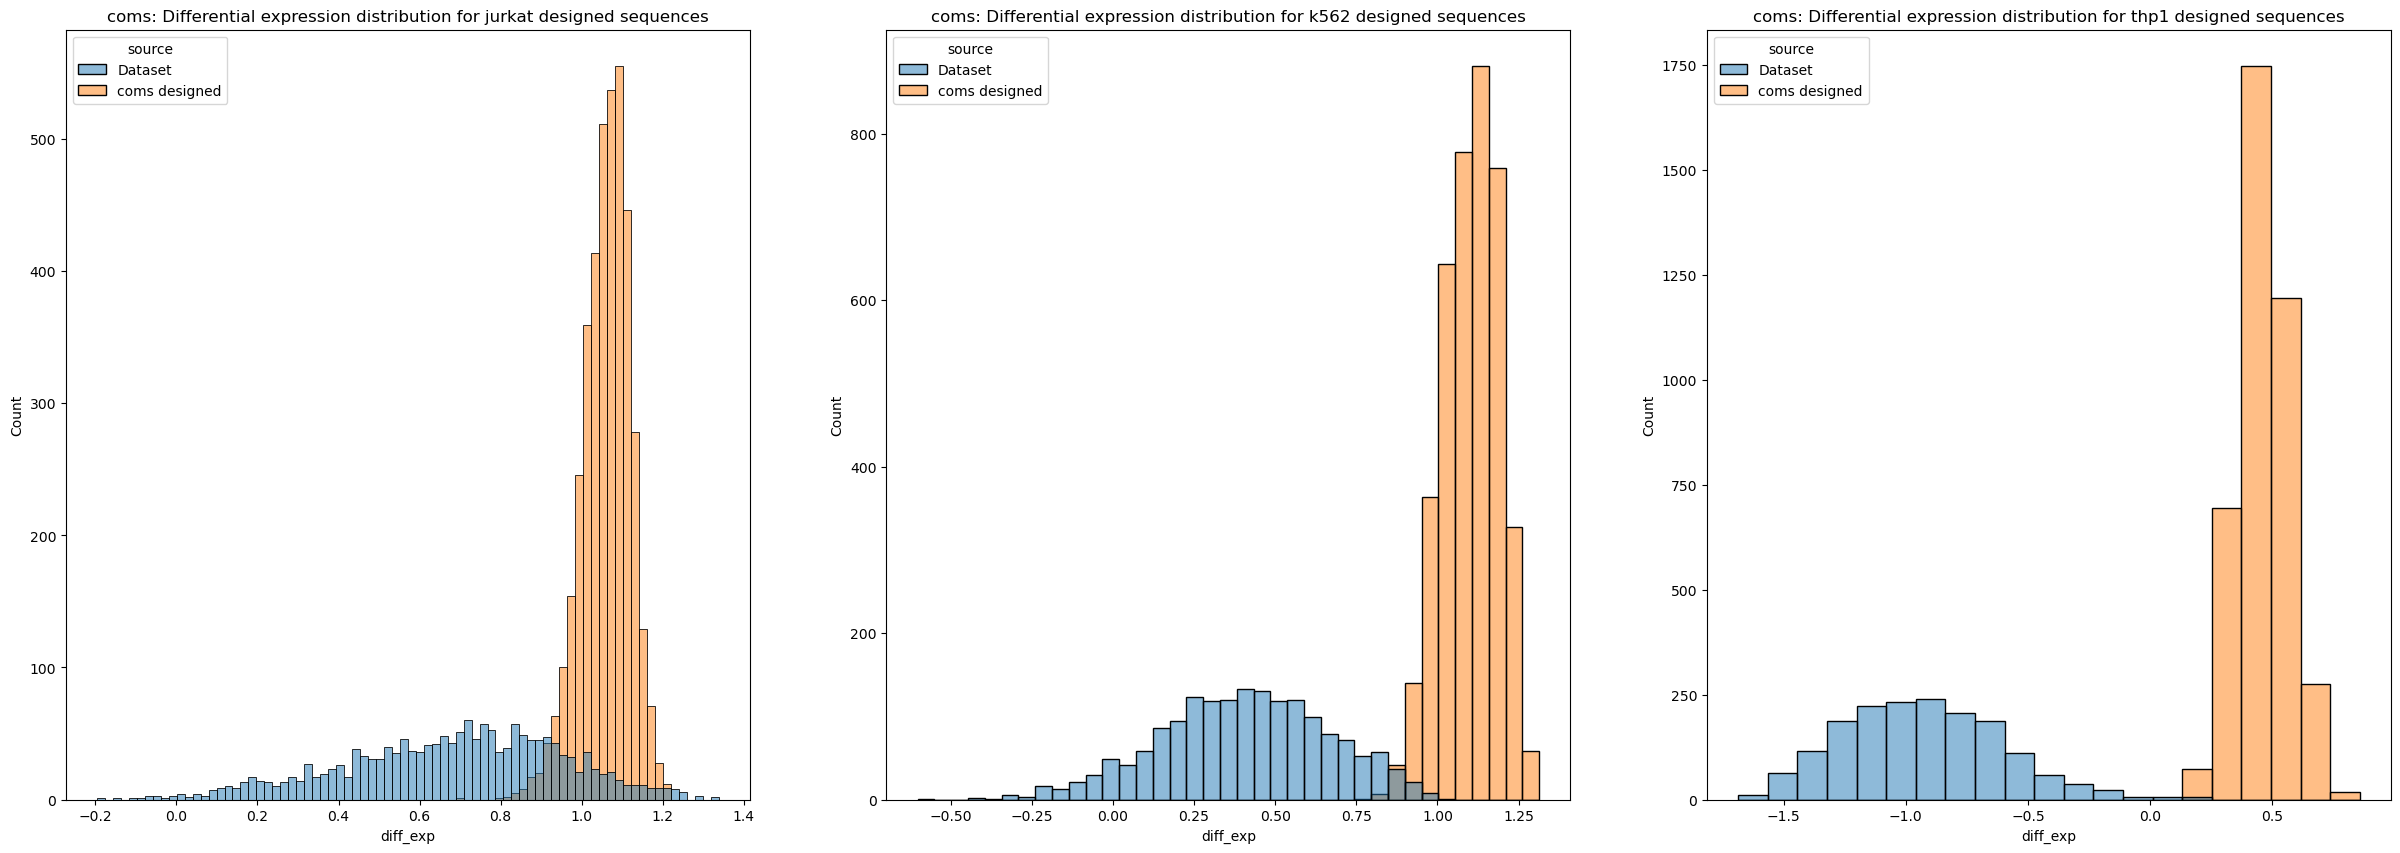

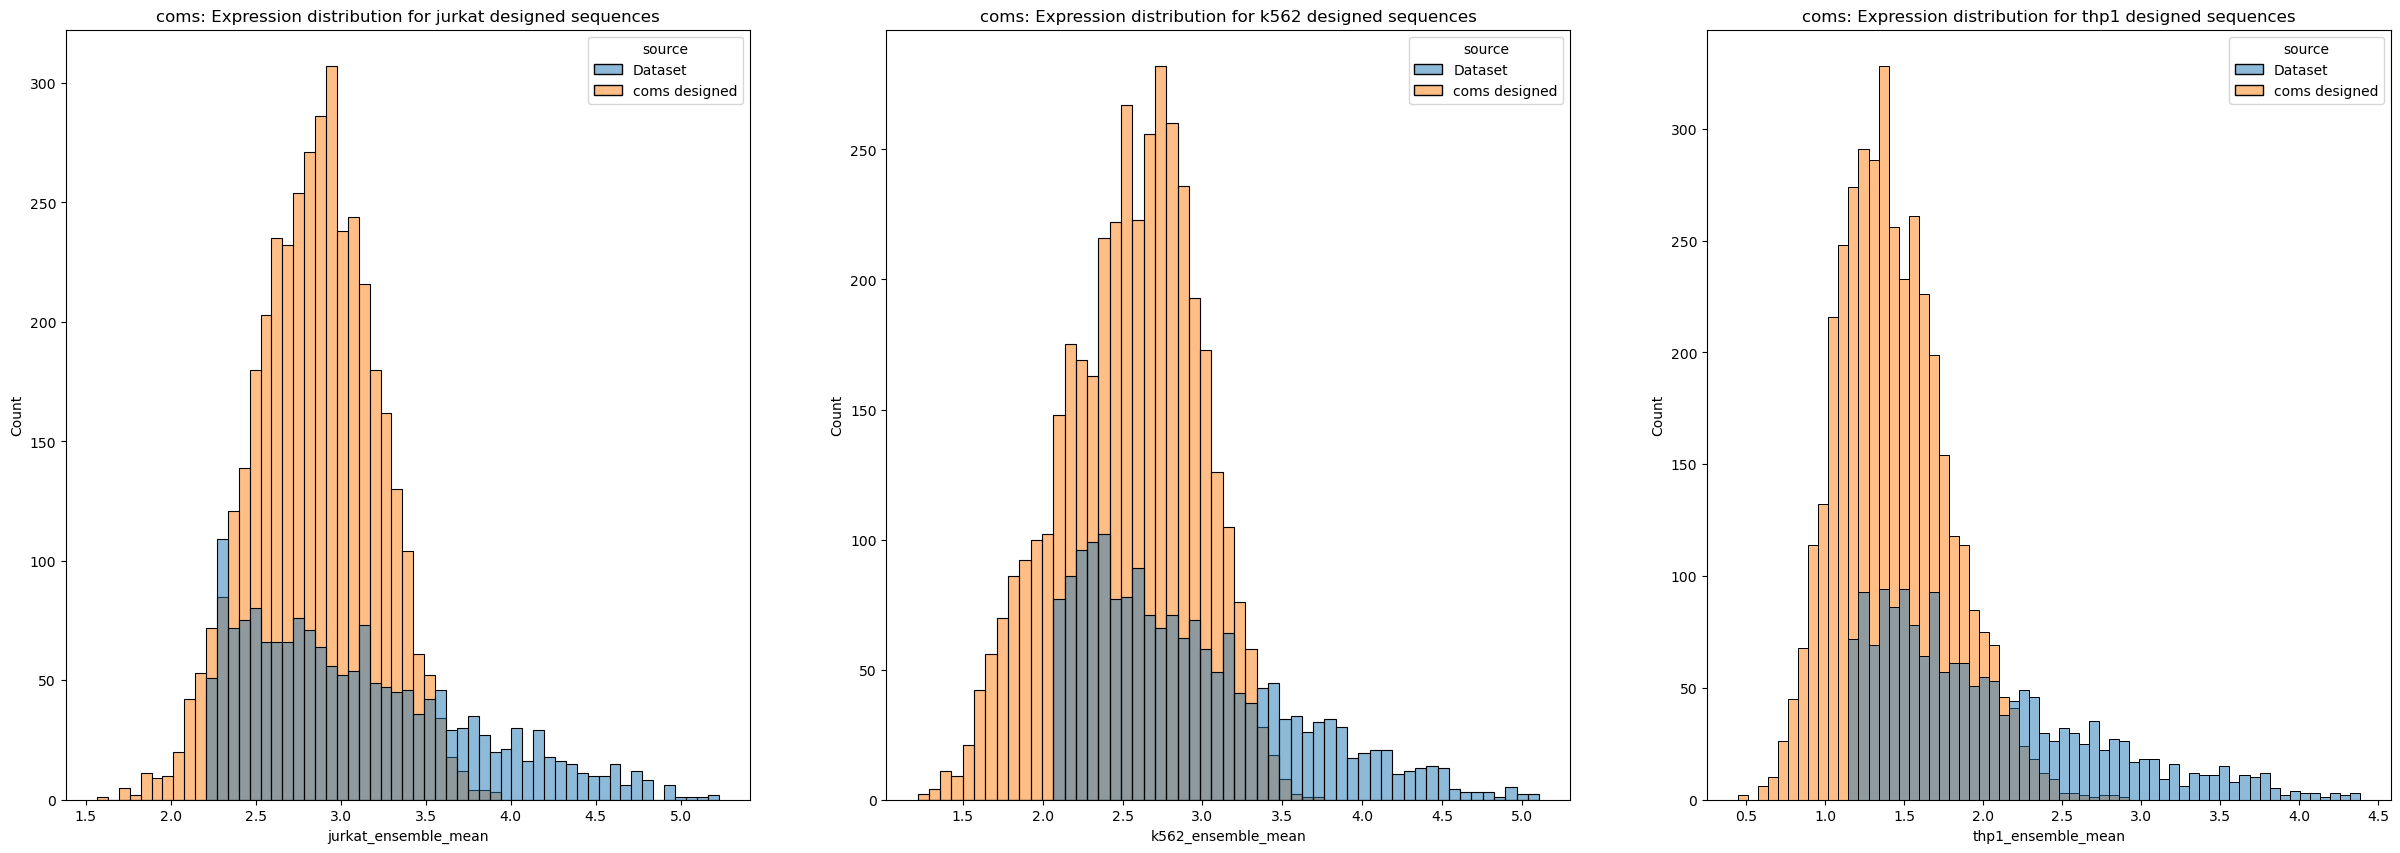

dens None
jurkat
k562
thp1


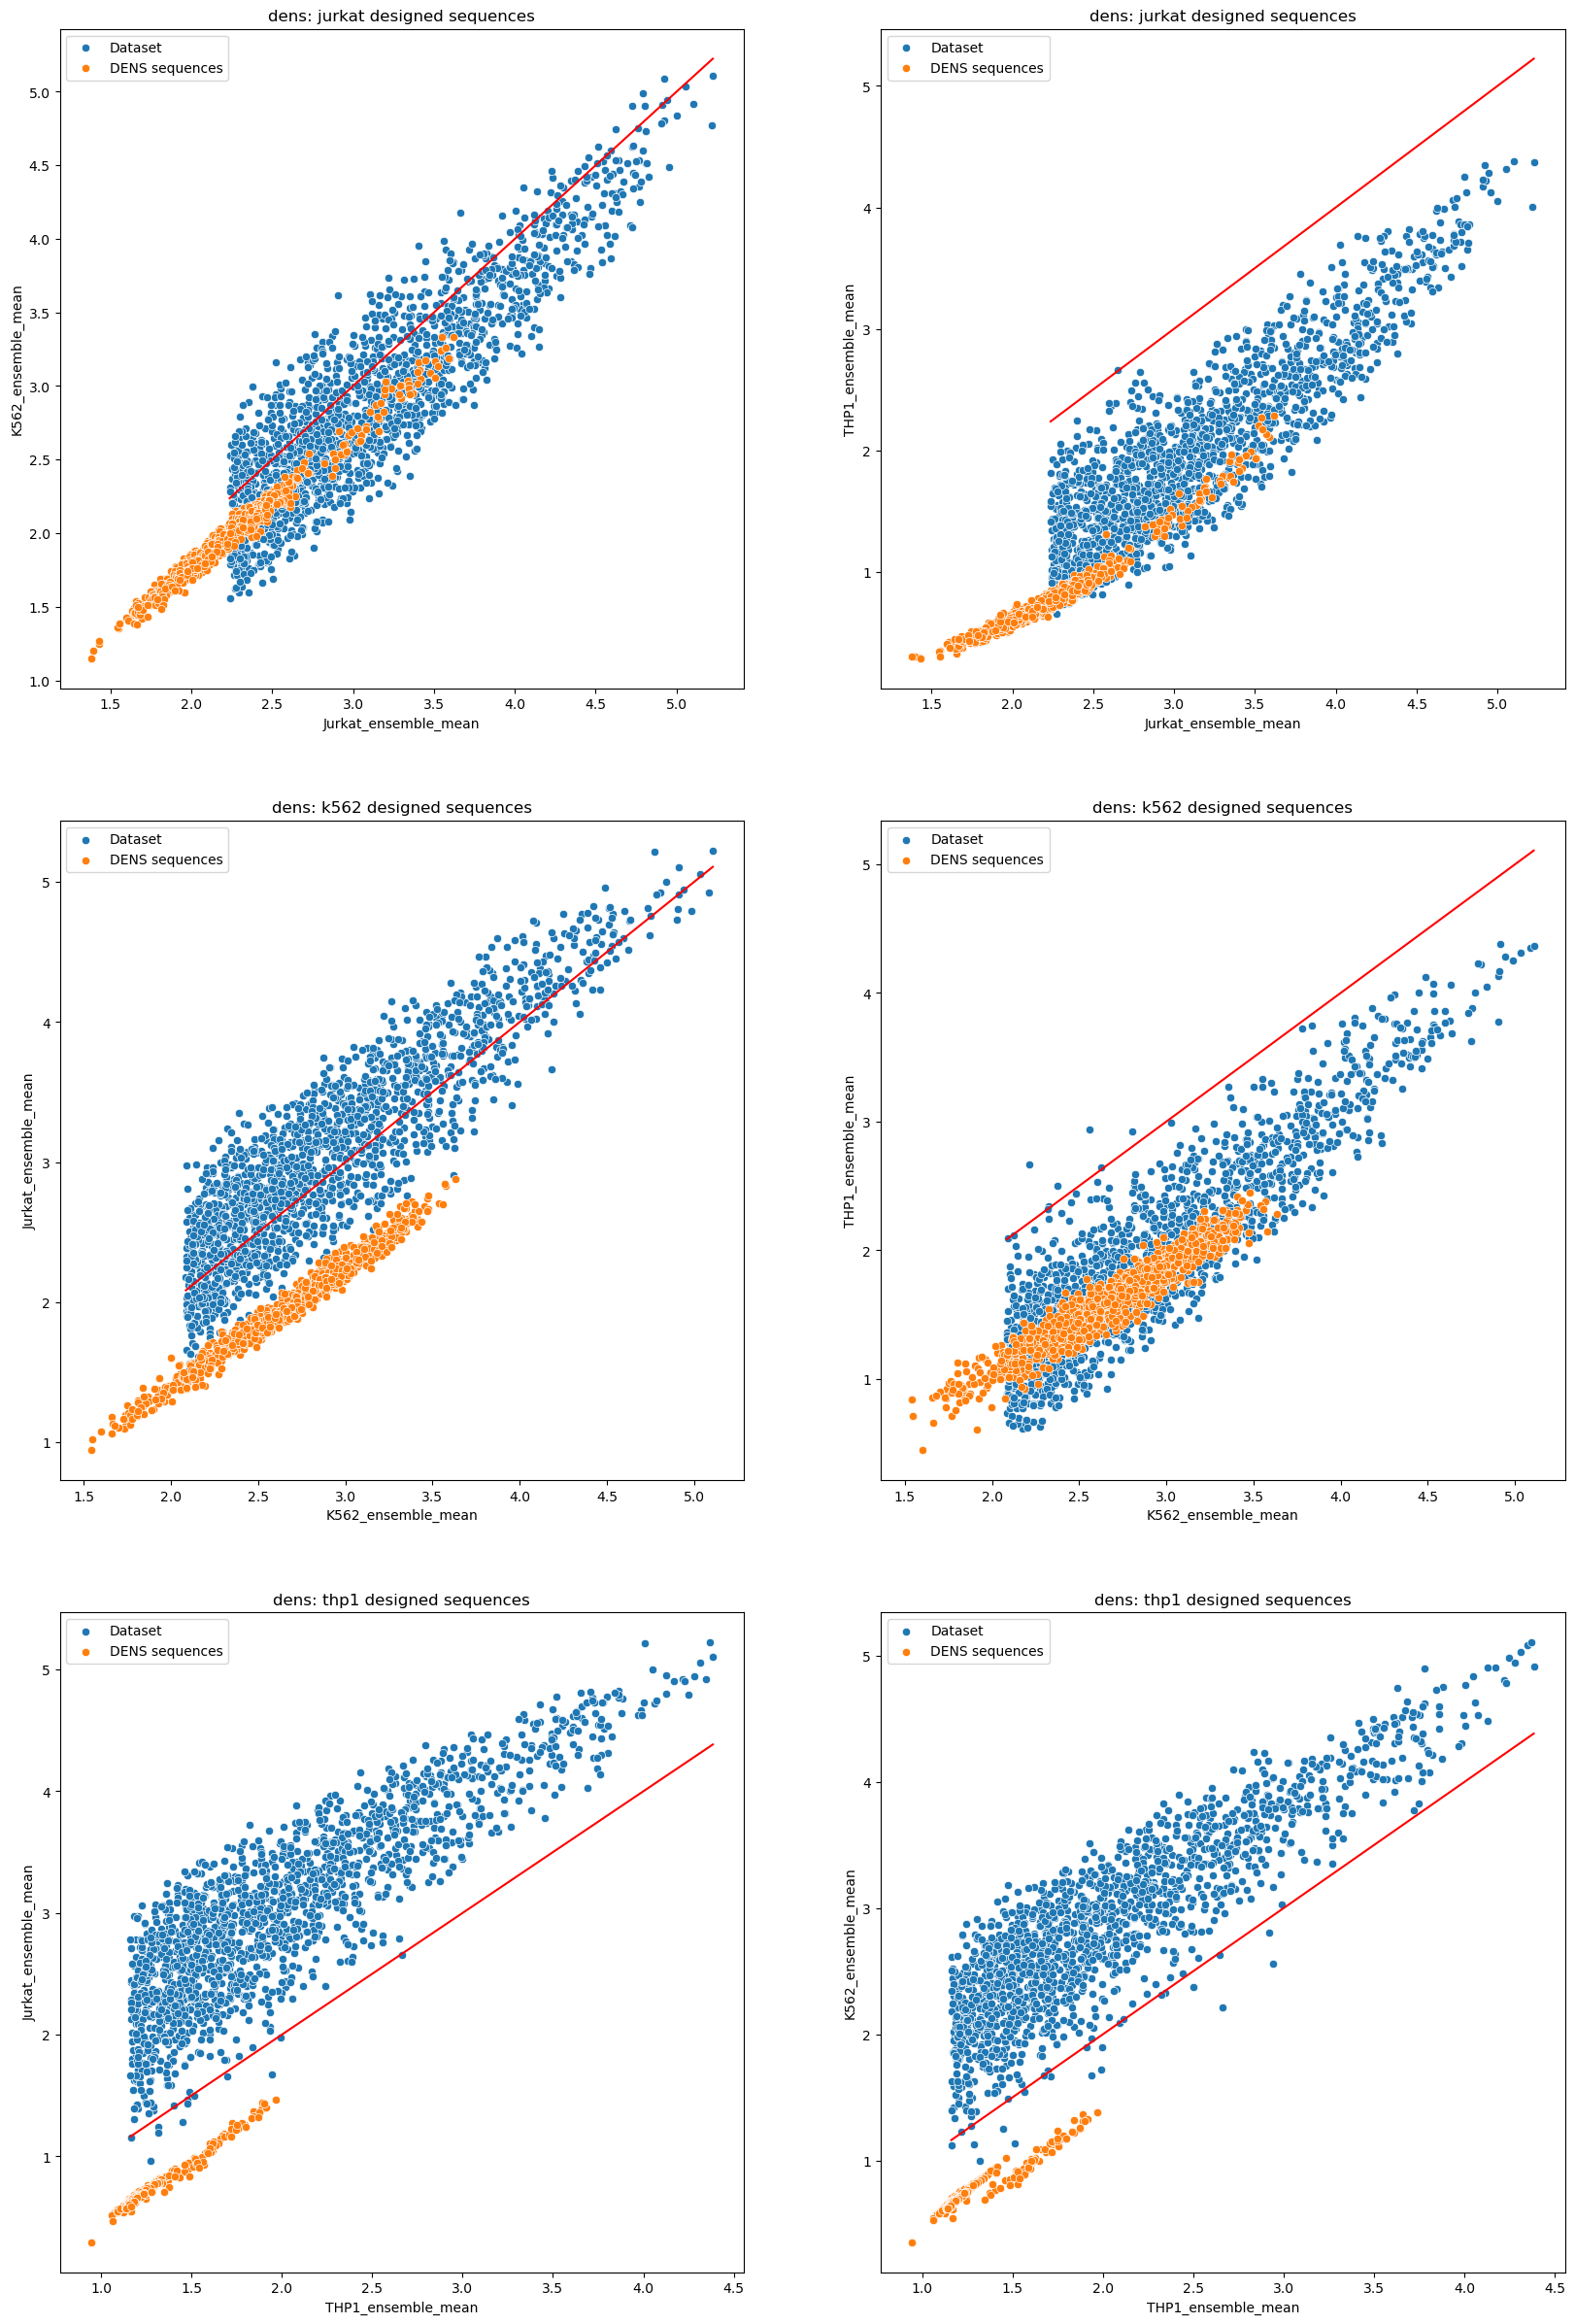

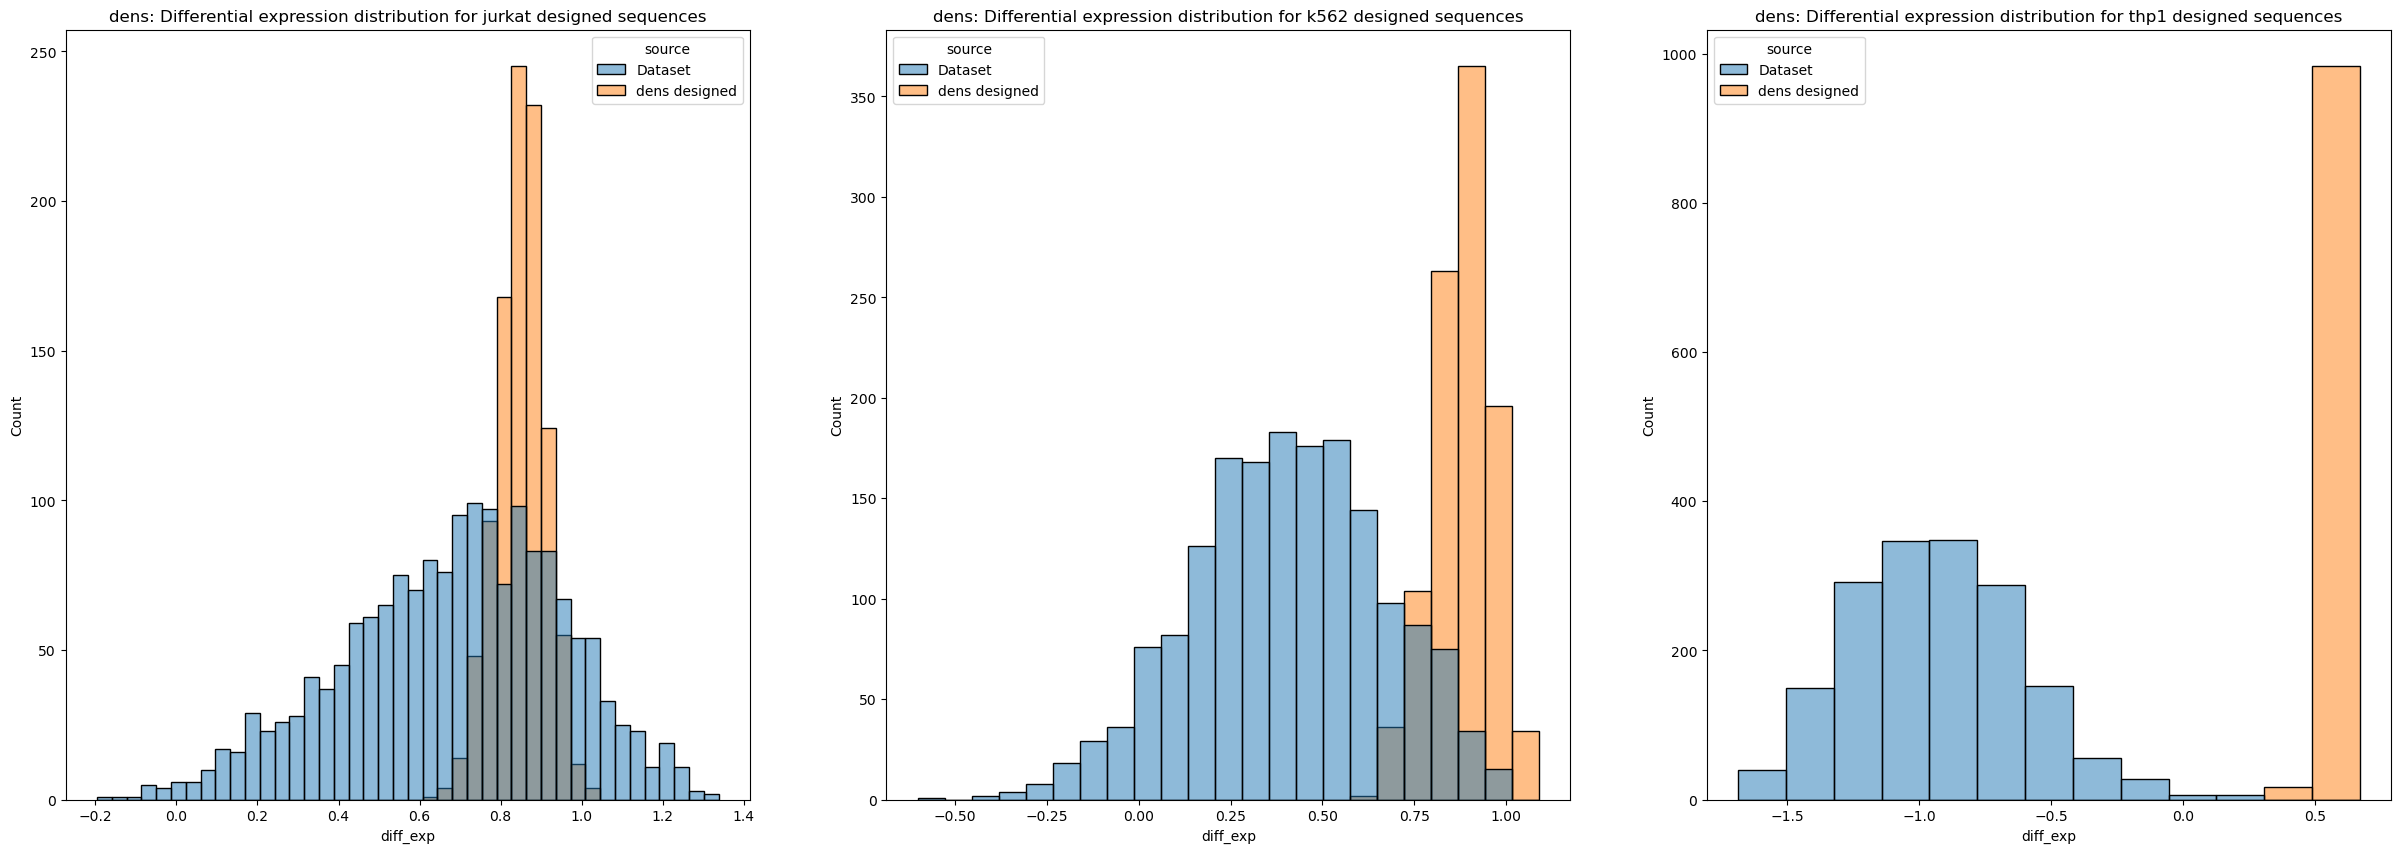

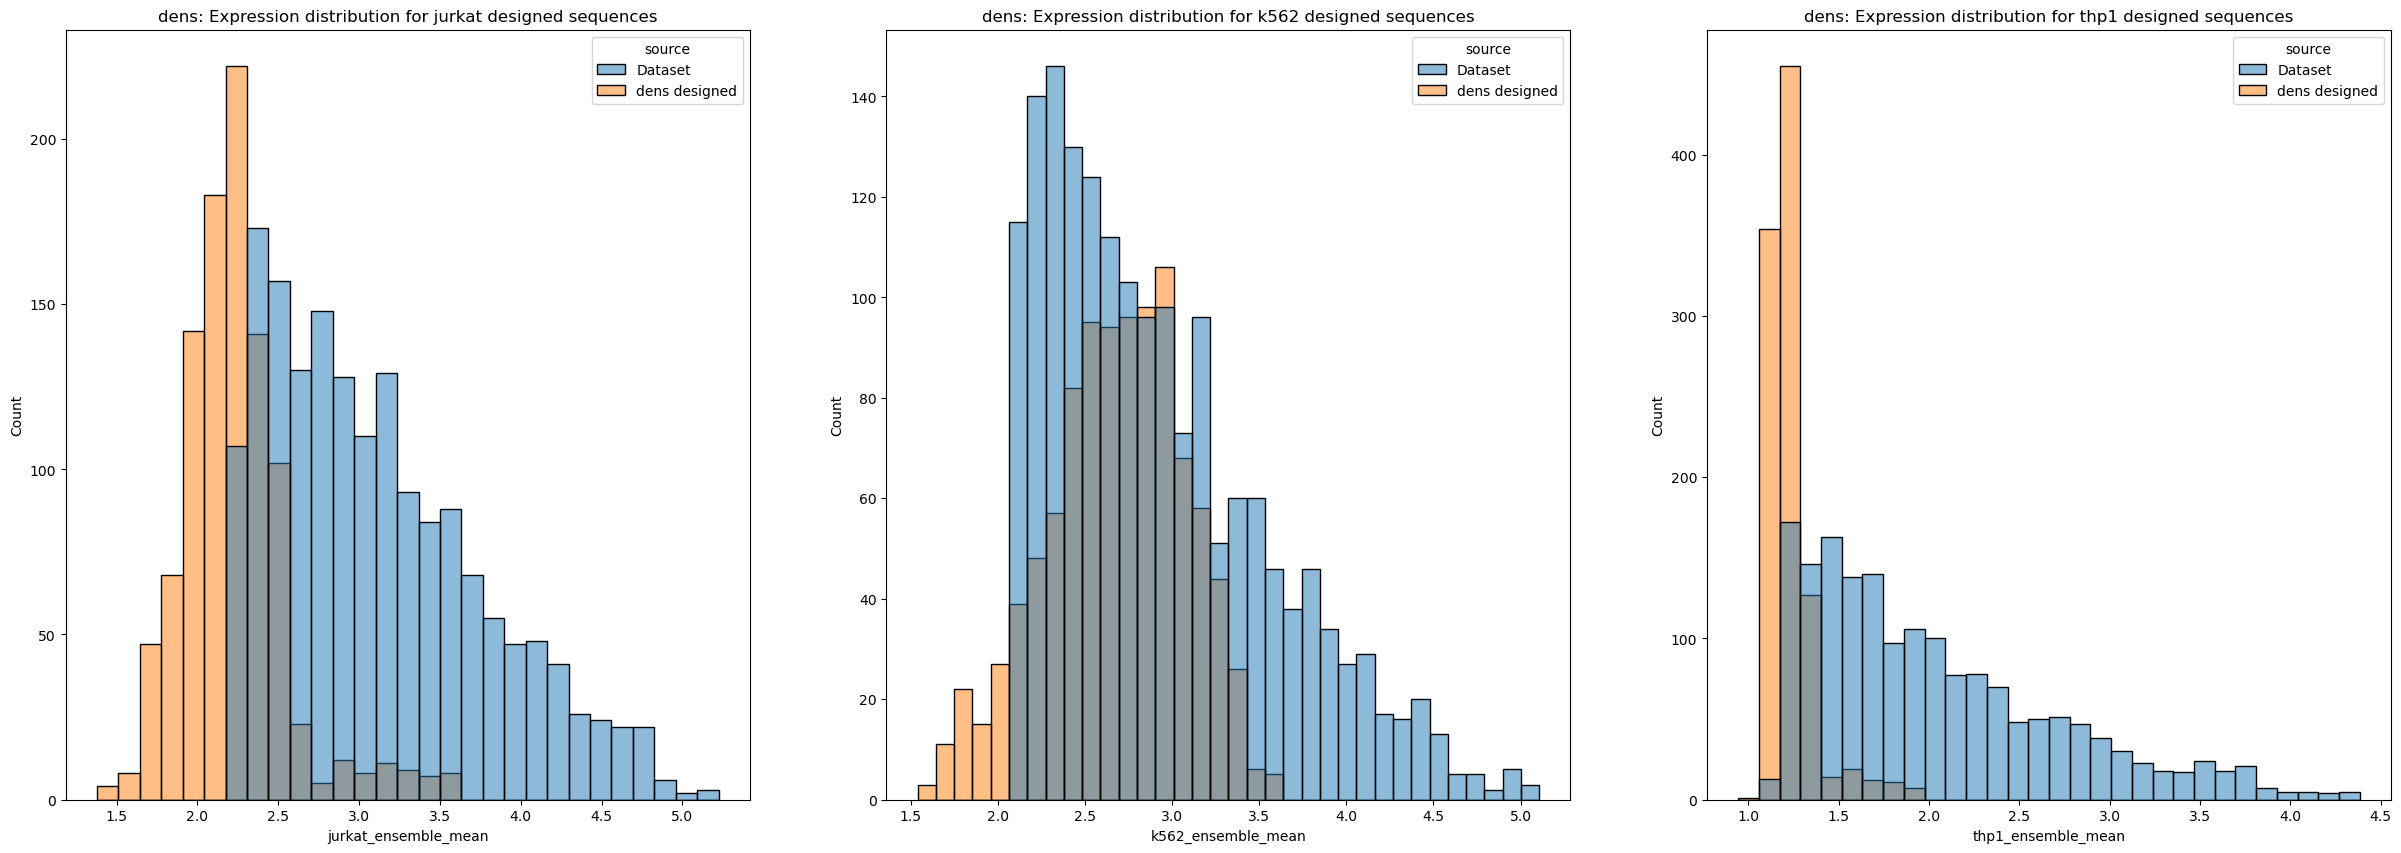

In [8]:
methods = ["coms", "dens"]
num_seqs = [None, None]

stats_df = {}
stats_df["Method"] = []
stats_df["Cell"] = []
stats_df["Min Exp"] = []
stats_df["Max Exp"] = []
stats_df["Avg Exp"] = []
stats_df["Median Exp"] = []
stats_df["Min DE"] = []
stats_df["Max DE"] = []
stats_df["Avg DE"] = []
stats_df["Median DE"] = []

# v1 sequences
name_map = {"jurkat": "Jurkat", "k562": "K562", "thp1": "THP1"}
for i, method in enumerate(methods):
    print(method, num_seqs[i])
    if method == "dens":
        seqs = pickle.load(open(os.path.join(final_design_seqs_dir, f"{method}_final_design_v2_seqs_v14.pkl"), "rb"))
    else:
        seqs = pickle.load(open(os.path.join(final_design_seqs_dir, f"{method}_final_design_v2.pkl"), "rb"))
    seqs_df = []
    kmer_features = {}
    for cell in ["jurkat", "k562", "thp1"]:
        kmer_features[cell] = seqs[cell]["kmer_features"]
        seqs[cell].pop("kmer_features")
        df = pd.DataFrame(seqs[cell])
        df["designed_for"] = cell
        
        if num_seqs[i] is not None:
            df = df.tail(num_seqs[i])
        
        seqs_df.append(df)
    
    seqs_df = pd.concat(seqs_df).reset_index(drop=True)
    
    ensemble_0_dataset_seqs = ensemble_0_filtered_sequences[ensemble_0_filtered_sequences["design_method"] == "Dataset"].reset_index(drop=True)
    fix, ax = plt.subplots(3, 2, figsize=(20, 30))
    fix2, ax2 = plt.subplots(1, 3, figsize=(30, 10))
    fix3, ax3 = plt.subplots(1, 3, figsize=(30, 10))
    for j, cell in enumerate(["jurkat", "k562", "thp1"]):
        subset_df = seqs_df[seqs_df["designed_for"] == cell].reset_index(drop=True)
        ensemble_0_dataset_seqs_90th_percentile_exp = np.percentile(ensemble_0_dataset_seqs[f"{name_map[cell]}_ensemble_mean"], 90)
        ensemble_0_dataset_seqs_target_cell = ensemble_0_dataset_seqs[ensemble_0_dataset_seqs[f"{name_map[cell]}_ensemble_mean"] >= ensemble_0_dataset_seqs_90th_percentile_exp].reset_index(drop=True)
        
        # pairwise expression scatter plots
        c = 0
        for k, cell2 in enumerate(["jurkat", "k562", "thp1"]):
            if j == k:
                continue
            sns.scatterplot(data=ensemble_0_dataset_seqs_target_cell, 
                            x=f"{name_map[cell]}_ensemble_mean", 
                            y=f"{name_map[cell2]}_ensemble_mean", 
                            ax=ax[j][c], label="Dataset")
            sns.scatterplot(data=subset_df, 
                            x=cell+"_mean_1", 
                            y=cell2+"_mean_1", 
                            ax=ax[j][c], label=f"{method.upper()} sequences")
            ax[j][c].plot(np.linspace(ensemble_0_dataset_seqs_target_cell[f"{name_map[cell]}_ensemble_mean"].min(), ensemble_0_dataset_seqs_target_cell[f"{name_map[cell]}_ensemble_mean"].max(), 10), 
                     np.linspace(ensemble_0_dataset_seqs_target_cell[f"{name_map[cell]}_ensemble_mean"].min(), ensemble_0_dataset_seqs_target_cell[f"{name_map[cell]}_ensemble_mean"].max(), 10),
                     "r-", label="x=y")
            ax[j][c].set_title(f"{method}: {cell} designed sequences")
            c += 1
        
        # stats + distribution plots
        combined_df = {}
        combined_df["sequence"] = list(ensemble_0_dataset_seqs_target_cell["sequence"]) + list(subset_df["sequences"])
        combined_df["source"] = ["Dataset" for k in list(ensemble_0_dataset_seqs_target_cell["sequence"])] + \
                                [f"{method} designed" for k in list(subset_df["sequences"])]
        
        for k, cell2 in enumerate(["jurkat", "k562", "thp1"]):
            combined_df[f"{cell2}_ensemble_mean"] = np.array(list(ensemble_0_dataset_seqs_target_cell[f"{name_map[cell2]}_ensemble_mean"]) + list(subset_df[cell2+"_mean_1"]))
        
        combined_df["diff_exp"] = combined_df[f"{cell}_ensemble_mean"].copy()
        for k, cell2 in enumerate(["jurkat", "k562", "thp1"]):
            if j == k:
                continue
            combined_df["diff_exp"] -= 0.5 * combined_df[f"{cell2}_ensemble_mean"]
        
        combined_df = pd.DataFrame(combined_df)        
        
        print(cell)
        for s, sdf in combined_df.groupby(by="source"):        
            stats_df["Method"].append(s)
            stats_df["Cell"].append(cell)
            
            stats_df["Min Exp"].append(sdf[f"{cell}_ensemble_mean"].min().round(3))
            stats_df["Max Exp"].append(sdf[f"{cell}_ensemble_mean"].max().round(3))
            stats_df["Avg Exp"].append(sdf[f"{cell}_ensemble_mean"].mean().round(3))
            stats_df["Median Exp"].append(sdf[f"{cell}_ensemble_mean"].median().round(3))
            
            stats_df["Min DE"].append(sdf["diff_exp"].min().round(3))
            stats_df["Max DE"].append(sdf["diff_exp"].max().round(3))
            stats_df["Avg DE"].append(sdf["diff_exp"].mean().round(3))
            stats_df["Median DE"].append(sdf["diff_exp"].median().round(3))
            
        # distribution of differential expression vs. dataset
        sns.histplot(data=combined_df, x="diff_exp", hue="source", ax=ax2[j])
        ax2[j].set_title(f"{method}: Differential expression distribution for {cell} designed sequences")
            
        # distribution of expression vs. dataset
        sns.histplot(data=combined_df, x=f"{cell}_ensemble_mean", hue="source", ax=ax3[j])
        ax3[j].set_title(f"{method}: Expression distribution for {cell} designed sequences")
        
    # show the plot
    plt.show()

In [6]:
stats_df = pd.DataFrame(stats_df).drop_duplicates().sort_values(by=["Cell", "Method"]).reset_index(drop=True)
stats_df.to_csv("QC0_stats_threshold_dataset_90th_percentile_DENs_v14.tsv", sep="\t", index=None)

In [7]:
stats_df

,Method,Cell,Min Exp,Max Exp,Avg Exp,Median Exp,Min DE,Max DE,Avg DE,Median DE
0,Dataset,jurkat,1.994,4.491,2.806,2.697,-0.147,1.126,0.545,0.570
1,coms designed,jurkat,1.566,3.916,2.851,2.861,0.705,1.215,1.059,1.065
2,dens designed,jurkat,1.378,3.618,2.228,2.204,0.642,1.026,0.850,0.855
3,Dataset,k562,1.954,4.477,2.740,2.632,-0.399,1.099,0.449,0.456
4,coms designed,k562,1.217,3.711,2.540,2.577,0.782,1.313,1.101,1.108
5,dens designed,k562,1.540,3.634,2.675,2.700,0.646,1.090,0.883,0.891
6,Dataset,thp1,1.046,4.077,1.838,1.701,-1.700,0.150,-0.887,-0.883
7,coms designed,thp1,0.448,2.920,1.430,1.390,0.170,0.858,0.464,0.462
8,dens designed,thp1,0.944,1.968,1.231,1.205,0.471,0.668,0.517,0.513
